In [1]:
require(data.table)
require(dplyr)
require(tidyverse)
require(phyloseq)
require(genefilter)
require(ggplot2)
require(vegan)
require(RColorBrewer)
require(metacoder)
options(repr.plot.width=20, repr.plot.height=15)

Loading required package: data.table

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   4.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::l

In [2]:
ps<-readRDS(file = "/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/RDS/ps.rds")
#removing any taxa that don't show up in any samples to speed up the process
ps <- prune_taxa(taxa_sums(ps) > 0, ps)

In [3]:
#getting rid of samples in phyloseq with very low-abundance or rarely occurring taxa
    # Remove taxa not seen in at least 3 samples AND total abundance less than 6
    ps <- phyloseq::filter_taxa(ps, function(x) sum(x > 0) > 2 & sum(x) > 5, TRUE)

In [4]:
head(sample_data(ps))

,Health_Status,colony,Date_16S,double_band,date_sampled,transect,species,MonthYear,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA,⋯,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGCCGTGGTGTGTTTGGAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTTTAATGATACGGCGACCACCGAGATCTACACAATTCCGGTCGTCGGCAGCGTCAGATGTGTATAAGAGACAGGT,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGCCGTGGTGTGTTTGGAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTTAATGATACGGCGACCACCGAGATCTACACAATTCCGGTCGTCGGCAGCGTCAGATGTGTATAAGAGACAGGT,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACGCATGTCTATCTGGTGTGGCGGGGTTTGTTTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGGCGGGGTGTGGTTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,input,filtered,denoisedF,denoisedR,merged,nonchim
,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<fct>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
012024_BEL_CBC_T1_557_SSID,Healthy,1_3,3_4_2025,y,012024,T1,SSID,Jan 2024,580,0,⋯,0,0,0,0,189570,176082,171436,173162,142705,129120
012024_BEL_CBC_T1_563_PSTR,Healthy,1_12,3_6_2025,,012024,T1,PSTR,Jan 2024,0,0,⋯,0,0,0,0,98511,89332,88739,88868,87695,44586
012024_BEL_CBC_T2_601_OFAV,Healthy,2_79,3_4_2025,,012024,T2,OFAV,Jan 2024,279,6,⋯,0,0,0,0,280308,263766,262084,262620,250901,173382
012024_BEL_CBC_T3_631_MCAV,Healthy,3_21,3_4_2025,,012024,T3,MCAV,Jan 2024,328,0,⋯,0,0,0,0,536790,497421,495886,496193,481028,404924
012024_BEL_CBC_T3_633_MCAV,Healthy,3_2,3_6_2025,,012024,T3,MCAV,Jan 2024,0,0,⋯,0,0,0,0,163169,154836,154032,153929,151918,62656
012024_BEL_CBC_T3_637_SSID,Healthy,3_5,3_6_2025,,012024,T3,SSID,Jan 2024,0,128,⋯,0,0,0,0,22749,21151,20332,20453,19464,17819


DESeq doesnt like normalized

In [5]:
#normalizing ps by converting rawcounts into relative abundances
#so samples with more reads wont be over represented
#using ps bc only to the count data (OTU table), while preserving the rest of the object
ps_norm = transform_sample_counts(ps, function(x) 1E6 * x / sum(x))

In [5]:
#isolate just bacteria
ps_bac=subset_taxa(ps, Kingdom=="Bacteria")
ps_bac

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11324 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95314 sample variables ]
tax_table()   Taxonomy Table:    [ 11324 taxa by 6 taxonomic ranks ]

In [6]:
#remove chloroplast order
ps_nochlo=subset_taxa(ps_bac, Order!="Chloroplast")
ps_nochlo

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9044 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95314 sample variables ]
tax_table()   Taxonomy Table:    [ 9044 taxa by 6 taxonomic ranks ]

In [7]:
ps_clean=subset_taxa(ps_nochlo, Family!="Mitochondria")

In [10]:
theme_set(theme_bw())

In [11]:
#choosing plot colors 
mycolors= colorRampPalette(brewer.pal(8, "Set3"))(8)

### ps objects to otu table and sample metadata

In [8]:
# convert the sample_data() within a phyloseq object to a vegan compatible data object
pssd2veg <- function(ps_clean) {
  sd_nochlo <- sample_data(ps_clean)
  return(as(sd_nochlo,"data.frame"))
}

#using phyloseq nmds plot no chloroplast
sample_clean <- pssd2veg(ps_clean)

In [9]:
# convert the otu_table() within a phyloseq object to a vegan compatible data object
psotu2veg <- function(ps_clean) {
  otu_clean <- otu_table(ps_clean)
  if (taxa_are_rows(otu_clean)) {
    otu_clean <- t(otu_clean)
  }
  return(as(otu_clean, "matrix"))
}

# Extract normalized OTU matrix and sample data
otu_clean <- psotu2veg(ps_clean)


In [30]:
# transposing otu for deseq compatibility 
otu <- t(otu_clean)

In [33]:
class(otu)

[1] "matrix" "array"

### Subgrouping to get parent groups for DEseq2

In [12]:
set.seed(12)

In [13]:
#making plots small 
options(repr.plot.width = 15, repr.plot.height = 10)
#dissimilarity
dij <- vegdist(otu_clean) ## bray curtis dissimilarity
clu <- hclust(dij, method = "average")
# 2 clusters bc I know Date_16S is already driving into 2 clusters
grp <- cutree(clu, 2)

In [14]:
# Subset your original data
# Get indices of samples in each parent cluster
grp1_ids <- names(grp[grp == 1])
grp2_ids <- names(grp[grp == 2])
head(grp1_ids)
class(grp1_ids)

[1] "012024_BEL_CBC_T1_557_SSID"  "012024_BEL_CBC_T2_601_OFAV" 
[3] "012024_BEL_CBC_T3_631_MCAV"  "022024_BEL_CBC_T1_776_PSTR" 
[5] "022024_BEL_CBC_T3_851_PSTR"  "042024_BEL_CBC_T2_1018_PAST"

[1] "character"

In [15]:
#create DEseq2 df with sample names and parent plot asv diff
# Create logical vectors indicating membership in each group
# Assign cluster labels directly using cutree output
sample_clean$Cluster <- paste0("Cluster", grp[rownames(sample_clean)])

# Convert to factor (important for DESeq2)
sample_clean$Cluster <- factor(sample_clean$Cluster, levels = c("Cluster1", "Cluster2"))

#new column in 

In [16]:
head(sample_clean)


,Health_Status,colony,Date_16S,double_band,date_sampled,transect,species,MonthYear,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA,⋯,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGCCGTGGTGTGTTTGGAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTTAATGATACGGCGACCACCGAGATCTACACAATTCCGGTCGTCGGCAGCGTCAGATGTGTATAAGAGACAGGT,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACGCATGTCTATCTGGTGTGGCGGGGTTTGTTTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGGCGGGGTGTGGTTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,input,filtered,denoisedF,denoisedR,merged,nonchim,Cluster
,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<fct>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>
012024_BEL_CBC_T1_557_SSID,Healthy,1_3,3_4_2025,y,012024,T1,SSID,Jan 2024,580,0,⋯,0,0,0,189570,176082,171436,173162,142705,129120,Cluster1
012024_BEL_CBC_T1_563_PSTR,Healthy,1_12,3_6_2025,,012024,T1,PSTR,Jan 2024,0,0,⋯,0,0,0,98511,89332,88739,88868,87695,44586,Cluster2
012024_BEL_CBC_T2_601_OFAV,Healthy,2_79,3_4_2025,,012024,T2,OFAV,Jan 2024,279,6,⋯,0,0,0,280308,263766,262084,262620,250901,173382,Cluster1
012024_BEL_CBC_T3_631_MCAV,Healthy,3_21,3_4_2025,,012024,T3,MCAV,Jan 2024,328,0,⋯,0,0,0,536790,497421,495886,496193,481028,404924,Cluster1
012024_BEL_CBC_T3_633_MCAV,Healthy,3_2,3_6_2025,,012024,T3,MCAV,Jan 2024,0,0,⋯,0,0,0,163169,154836,154032,153929,151918,62656,Cluster2
012024_BEL_CBC_T3_637_SSID,Healthy,3_5,3_6_2025,,012024,T3,SSID,Jan 2024,0,128,⋯,0,0,0,22749,21151,20332,20453,19464,17819,Cluster2


In [17]:
table(sample_clean$Cluster) #35 and 22
any(is.na(sample_clean$Cluster))


Cluster1 Cluster2 
      35       22 

[1] FALSE

### DESeq2 set up

In [18]:
require(DESeq2)
package.version("DESeq2")

Loading required package: DESeq2

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:lubri

[1] "1.38.3"

In [19]:
# Step 1: Add the cleaned sample data (with cluster assignments) back to the phyloseq object
sample_data(ps_clean) <- sample_data(sample_clean)
head(sample_data(ps_clean))

,Health_Status,colony,Date_16S,double_band,date_sampled,transect,species,MonthYear,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA,⋯,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGCCGTGGTGTGTTTGGAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTTAATGATACGGCGACCACCGAGATCTACACAATTCCGGTCGTCGGCAGCGTCAGATGTGTATAAGAGACAGGT,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACGCATGTCTATCTGGTGTGGCGGGGTTTGTTTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGGCGGGGTGTGGTTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,input,filtered,denoisedF,denoisedR,merged,nonchim,Cluster
,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<fct>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>
012024_BEL_CBC_T1_557_SSID,Healthy,1_3,3_4_2025,y,012024,T1,SSID,Jan 2024,580,0,⋯,0,0,0,189570,176082,171436,173162,142705,129120,Cluster1
012024_BEL_CBC_T1_563_PSTR,Healthy,1_12,3_6_2025,,012024,T1,PSTR,Jan 2024,0,0,⋯,0,0,0,98511,89332,88739,88868,87695,44586,Cluster2
012024_BEL_CBC_T2_601_OFAV,Healthy,2_79,3_4_2025,,012024,T2,OFAV,Jan 2024,279,6,⋯,0,0,0,280308,263766,262084,262620,250901,173382,Cluster1
012024_BEL_CBC_T3_631_MCAV,Healthy,3_21,3_4_2025,,012024,T3,MCAV,Jan 2024,328,0,⋯,0,0,0,536790,497421,495886,496193,481028,404924,Cluster1
012024_BEL_CBC_T3_633_MCAV,Healthy,3_2,3_6_2025,,012024,T3,MCAV,Jan 2024,0,0,⋯,0,0,0,163169,154836,154032,153929,151918,62656,Cluster2
012024_BEL_CBC_T3_637_SSID,Healthy,3_5,3_6_2025,,012024,T3,SSID,Jan 2024,0,128,⋯,0,0,0,22749,21151,20332,20453,19464,17819,Cluster2


In [32]:
# Step 2: Ensure the order of samples in OTU matches the phyloseq object
otu <- otu[, sample_names(ps_clean)]

# Step 3: Replace the OTU table in the phyloseq object
otu_table(ps_clean) <- otu_table(otu, taxa_are_rows = TRUE)
head(otu_table(ps_clean))

,012024_BEL_CBC_T1_557_SSID,012024_BEL_CBC_T1_563_PSTR,012024_BEL_CBC_T2_601_OFAV,012024_BEL_CBC_T3_631_MCAV,012024_BEL_CBC_T3_633_MCAV,012024_BEL_CBC_T3_637_SSID,012024_BEL_CBC_T4_661_PSTR,022024_BEL_CBC_T1_776_PSTR,022024_BEL_CBC_T3_851_PSTR,022024_BEL_CBC_T4_875_MCAV,⋯,122022_BEL_CBC_T3_141_PSTR,122023_BEL_CBC_T1_507_PAST,122023_BEL_CBC_T1_508_SSID,122023_BEL_CBC_T2_515_PAST,122023_BEL_CBC_T2_518_MCAV,122023_BEL_CBC_T3_524_OFAV,122023_BEL_CBC_T3_525_PAST,122023_BEL_CBC_T3_526_SSID,122023_BEL_CBC_T3_531_PSTR,122023_BEL_CBC_T3_532_MCAV
TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,580,0,279,328,0,0,0,30,193,0,⋯,0,104,0,0,0,3669,0,68,0,39
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG,4781,0,2321,117,0,0,162,22,845,0,⋯,0,8990,0,0,0,1641,0,235,0,69
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGGGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG,60,0,119,0,0,0,76,0,318,0,⋯,0,4589,0,0,0,596,0,90,0,27
ATACGAAGGGAGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTGTAGGCGGATTATCAAGTTAGGGGTGAAATCCCGGGGCTCAACCTCGGCACTGCCTTTAAGACTGATAATCTAGAGTATGTGAGGGGATAATGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACACCAGTGGCGAAGGCGATTATCTGGCACATTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACGGGA,32,0,0,0,17,0,97,0,0,0,⋯,0,0,0,27,86,0,218,0,0,0
TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATTGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,367,0,543,121,0,0,0,0,0,0,⋯,0,103,0,0,0,894,0,52,0,39
TACGAAGGGAGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTGTAGGCGGATTATCAAGTTAGGGGTGAAATCCCGGGGCTCAACCTCGGCACTGCCTTTAAGACTGATAATCTAGAGTATGTGAGGGGATAATGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACACCAGTGGCGAAGGCGATTATCTGGCACATTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCGAACGGG,0,34,0,0,0,0,0,0,364,64,⋯,0,0,0,0,0,0,0,114,83,46


In [35]:
cluster_dds = phyloseq_to_deseq2(ps_clean, ~ Cluster)
gm_mean = function(row) if (all(row == 0)) 0 else exp(mean(log(row[row != 0])))
geoMeans = apply(otu, 1, gm_mean)
cluster_dds <- estimateSizeFactors(cluster_dds, geoMeans=geoMeans, locfunc=shorth)

cluster_dds = DESeq(cluster_dds, test="Wald", fitType="parametric")

converting counts to integer mode

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 3758 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



DESeq2 is trying to fit the otus into a a regression (GLM) 
y = Bo + B1X1 ...
y= outcome of gene expression
Bo= baseline
x= value of cluster (1 or 2)
in my case there is only one factor (cluster) with two values (cluster1 and cluster2)

goal is to find DEGs between clusters, trying to find log (y*Bo)/B1

Ho: logFC=0, no DEGs between the two groups

In [36]:
resultsNames(cluster_dds)

[1] "Intercept"                    "Cluster_Cluster2_vs_Cluster1"

In [37]:
summary(cluster_dds)

[1] "DESeqDataSet object of length 6787 with 23 metadata columns"

### DESeq test results

In [46]:
# Extract results (Cluster1 vs Cluster2)
res = results(cluster_dds, cooksCutoff = FALSE, name = "Cluster_Cluster2_vs_Cluster1")
alpha = 0.05
# Filter for significantly differentially abundant taxa p adjusted value
sig_cluster = res[which(res$padj < alpha), ]
# Combine with taxonomy information (from the same phyloseq object used for DESeq2)
sig_cluster = cbind(as(sig_cluster, "data.frame"), as(tax_table(ps_clean)[rownames(sig_cluster), ], "matrix"))
NROW(sig_cluster)

[1] 713

### look at the OTUs that were significantly different between the two tissues. 

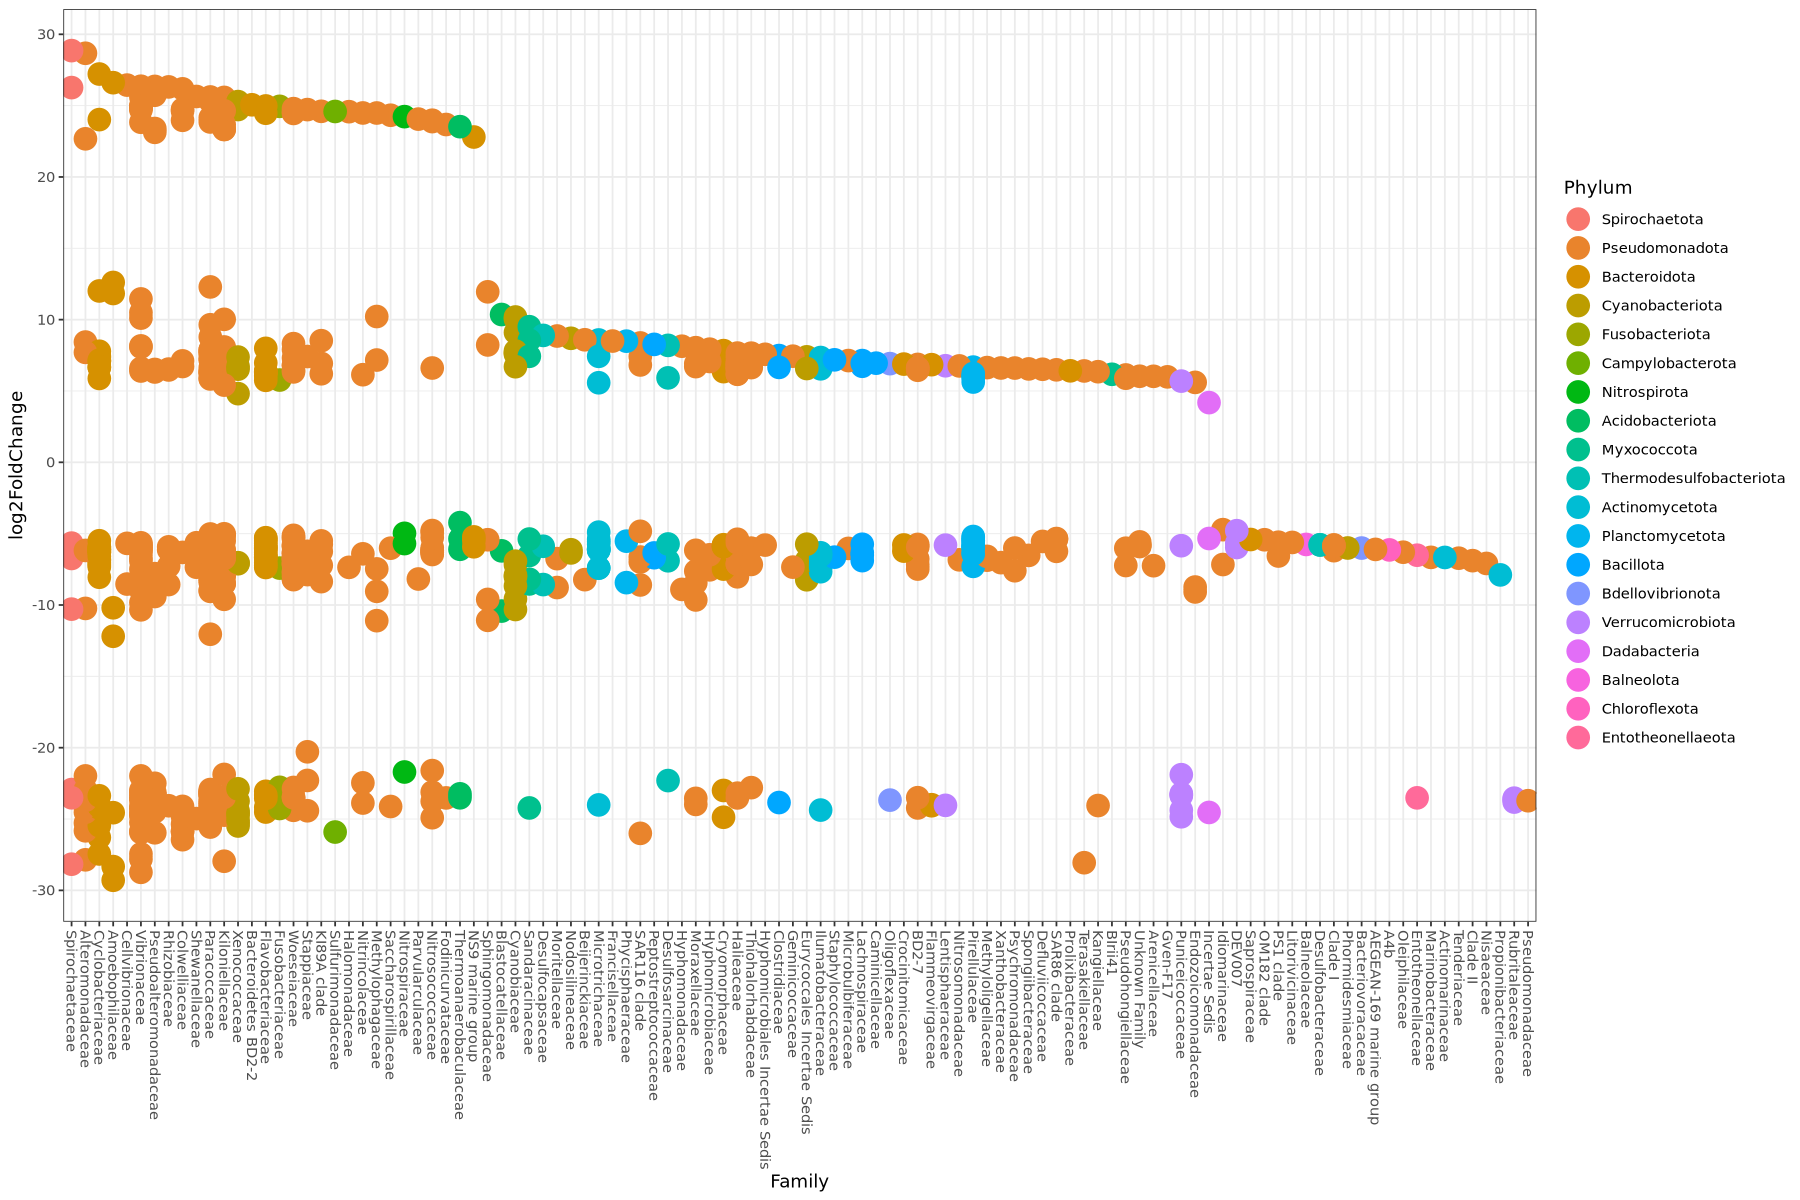

In [47]:
scale_fill_discrete <- function(palname = "Set3", ...) {
    scale_fill_brewer(palette = palname, ...)
}
# Phylum order
x = tapply(sig_cluster$log2FoldChange, sig_cluster$Phylum, function(x) max(x))
x = sort(x, TRUE)
sig_cluster$Phylum = factor(as.character(sig_cluster$Phylum), levels=names(x))
# Genus order
x = tapply(sig_cluster$log2FoldChange, sig_cluster$Family, function(x) max(x))
x = sort(x, TRUE)
sig_cluster$Family = factor(as.character(sig_cluster$Family), levels=names(x))
ggplot(sig_cluster, aes(x=Family, y=log2FoldChange, color=Phylum)) + geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))

In [42]:
sig_clust_simp=sig_cluster[,c("log2FoldChange", "Kingdom", "Phylum", "Class", "Order", "Family", "Genus")] 
sig_clust_simp <- as.matrix(sig_clust_simp)
sig_clust_simpTAX <- tax_table(sig_clust_simp)
sig_cluster_log <- ps_clean
tax_table(sig_cluster_log)=sig_clust_simpTAX

In [50]:
sig_clust_wlog_filter <- genefilter_sample(sig_cluster_log, filterfun_sample(function(x) x > 1), A=0.33*nsamples(sig_cluster_log))
sig_clust_wlog_prune <- prune_taxa(sig_clust_wlog_filter, sig_cluster_log)
tax_table(sig_clust_wlog_prune)                                                                   

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 101 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95315 sample variables ]
tax_table()   Taxonomy Table:    [ 101 taxa by 7 taxonomic ranks ]

In [51]:
clean_sig_wlog_prune <- sig_clust_wlog_prune[tax_table(sig_clust_wlog_prune(log2FoldChange)) > 10, ]  
clean_sig_wlog_prune 

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'i' in selecting a method for function '[': error in evaluating the argument 'object' in selecting a method for function 'tax_table': could not find function "sig_clust_wlog_prune"


In [49]:
class(sig_clust_wlog_prune)

[1] "phyloseq"
attr(,"package")
[1] "phyloseq"

In [ ]:
## can't do this bc class(sig_clust_wlog_prune) is a phyloseq object

clean_sig_wlog_prune <- sig_clust_wlog_prune[sig_clust_wlog_prune$log2FoldChange > 10, ]  
clean_sig_wlog_prune 